In [20]:
import torch
import numpy as np
import torch.nn.functional as F
from PIL import Image
import os
import cv2

In [33]:
def cv2_polar(pic):    
    pic2 = cv2.linearPolar(pic, (pic.shape[0]/2,pic.shape[1]/2), pic.shape[0]/2, cv2.WARP_FILL_OUTLIERS)
    pic2 = cv2.rotate(pic2, cv2.ROTATE_90_COUNTERCLOCKWISE)
    return pic2
    # img_edge = pic[:160,:,:]    return pic2


In [89]:
def linear_polar_gpu(input_img, center):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_img = input_img.to(device)
    
    size = input_img.shape[2]  # width와 height가 같다고 가정
    max_radius = size/2  # 이미지 중심으로부터 구석까지의 최대 거리

    # 각도와 반경을 계산할 그리드 생성
    theta, r = torch.meshgrid(
        torch.linspace(0, 2 * np.pi, size, device=device),
        torch.linspace(0, max_radius, size, device=device),
        indexing='ij')
    x = r * torch.cos(theta) + center[0]
    y = r * torch.sin(theta) + center[1]

    # Normalize to -1 to 1 for grid_sample
    x_normalized = (x - size / 2) / (size / 2)
    y_normalized = (y - size / 2) / (size / 2)
    grid = torch.stack((x_normalized, y_normalized), dim=-1).unsqueeze(0)

    # grid_sample을 사용하여 극좌표 이미지 생성
    polar_img = F.grid_sample(input_img, grid, mode='bilinear', padding_mode='border', align_corners=False)
    polar_img = polar_img.rot90(1, [2, 3])

    return polar_img


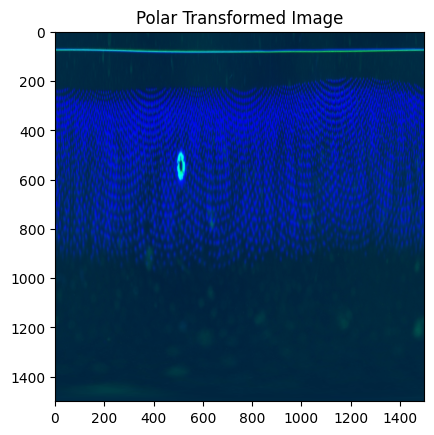

In [107]:

image_dir = 'E:/polar_data/check'
image_id = os.listdir(image_dir)[1]
image_path = f'{image_dir}/{image_id}'
image = Image.open(image_path).convert("RGB")
input_img = torch.tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255  # CHW format, add batch dim

# 이미지 중심점
center = (image.width // 2, image.height // 2)

# 극좌표 변환 실행 (GPU 사용)
polar_img = linear_polar_gpu(input_img, center)

# 결과 이미지 확인 (matplotlib 사용)
import matplotlib.pyplot as plt

polar_img_cpu = polar_img.cpu().squeeze().permute(1, 2, 0)  # Move to CPU for plotting
plt.imshow(polar_img_cpu.numpy())
plt.title("Polar Transformed Image")
plt.show()

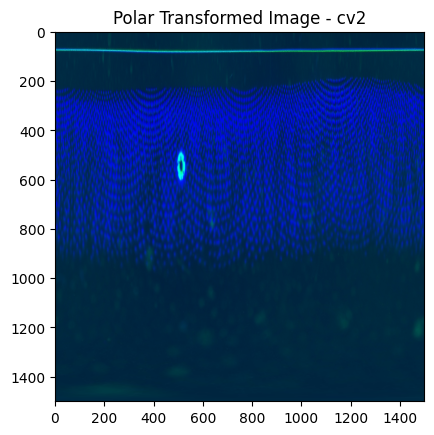

In [108]:
pic = cv2.imread(image_path)
pic2 = cv2_polar(pic)
pic2 = cv2.cvtColor(pic2, cv2.COLOR_BGR2RGB)

plt.imshow(pic2)
plt.title("Polar Transformed Image - cv2")
plt.show()

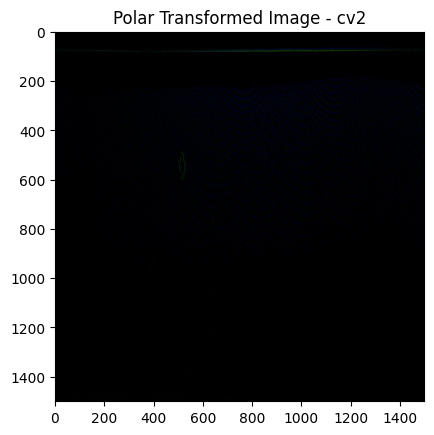

118.39552533333334

In [111]:
def mse(imageA, imageB):
    # 두 이미지의 차이를 계산한 후, 제곱하여 평균을 냅니다.
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    
    # MSE 결과 반환
    return err


if pic2.dtype != np.uint8:
    pic3 = (pic2 * 255).astype(np.uint8)
else:
    pic3 = pic2

if polar_img_cpu.numpy().dtype != np.uint8:
    polar_img_cpu3 = (polar_img_cpu.numpy() * 255).astype(np.uint8)
plt.imshow(cv2.subtract(pic3 , polar_img_cpu3))
plt.title("Polar Transformed Image - cv2")
plt.show()

mse(pic3, polar_img_cpu3)